In [1]:
#Import Libraries
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as XGBClassifierb
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix,precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'D:\Work_Station\ANN_RiceClassification_Using_Pytorch\src\riceClassification.csv')
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Target and Feature Columns

In [3]:
df.Class.value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

Using SOMTE and Data Split into train, validation, and test sets

In [6]:
def split_data_with_smote(X, y, train_size=0.6, val_size=0.2, test_size=0.2):
    # Calculate the remaining size after setting the test size
    remaining_size = 1 - test_size
    
    # Split data into training-validation set and test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Calculate the validation proportion from the remaining data
    val_proportion = val_size / (1 - test_size)
    
    # Split the training-validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=42, stratify=y_train_val
    )
    
    # Apply SMOTE to the training data only
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    return X_train_smote, X_val, X_test, y_train_smote, y_val, y_test

# Split the data
X_train_smote, X_val, X_test, y_train_smote, y_val, y_test = split_data_with_smote(X, y)

In [7]:
# Print percentages after SMOTE
print("After applying SMOTE:")
print(f"Training size: {len(X_train_smote) / (len(X_train_smote) + len(X_val) + len(X_test)) * 100:.2f}%")
print(f"Validation size: {len(X_val) / (len(X_train_smote) + len(X_val) + len(X_test)) * 100:.2f}%")
print(f"Test size: {len(X_test) / (len(X_train_smote) + len(X_val) + len(X_test)) * 100:.2f}%")


After applying SMOTE:
Training size: 62.22%
Validation size: 18.89%
Test size: 18.89%


Feature Scaling using Standard Scalar

In [8]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the SMOTE-transformed training data and transform it
X_train_scaled = scaler.fit_transform(X_train_smote)

In [9]:
# Transform the validation and test sets using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Model Selection

In [10]:
from xgboost import XGBClassifier  # Import XGBClassifier


# Define models
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Gaussian Discriminant Analysis (GDA)": QDA(),
    "Feed Forward Neural Network": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42) 
}

Evaluating Models

In [11]:
def evaluate_model(name, model, X_val_scaled, y_val):
    # Fit the model
    model.fit(X_train_scaled, y_train_smote)
    
    # Predict on validation set
    y_val_pred = model.predict(X_val_scaled)
    
    # Calculate probabilities if the model supports it
    y_val_proba = None
    if hasattr(model, "predict_proba"):
        y_val_proba = model.predict_proba(X_val_scaled)
    
    # Classification report
    report = classification_report(y_val, y_val_pred, output_dict=True)
    
    # Precision, Recall, F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_val_pred, average='weighted')
    
    # AUC ROC Score
    auc_roc = None
    if y_val_proba is not None:
        try:
            auc_roc = roc_auc_score(y_val, y_val_proba, multi_class='ovr')
        except ValueError:
            auc_roc = None  # Handle models that don't support probability prediction
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    return {
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC ROC': auc_roc,
        'Classification Report': report,
        'Confusion Matrix': conf_matrix
    }

In [12]:
results = []
for name, model in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(name, model, X_val_scaled, y_val)
    results.append(result)
    print(f"Results for {name}:")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print(f"AUC ROC: {result['AUC ROC']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Classification Report:\n{result['Classification Report']}\n")
    print("================================================================================================================================ \n")

Evaluating Logistic Regression...
Results for Logistic Regression:
Precision: 0.9997252156680014
Recall: 0.9997250481165796
F1 Score: 0.9997250555879653
AUC ROC: None
Confusion Matrix:
[[1640    0]
 [   1 1996]]
Classification Report:
{'0': {'precision': 0.9993906154783668, 'recall': 1.0, 'f1-score': 0.9996952148735142, 'support': 1640.0}, '1': {'precision': 1.0, 'recall': 0.99949924887331, 'f1-score': 0.9997495617330328, 'support': 1997.0}, 'accuracy': 0.9997250481165796, 'macro avg': {'precision': 0.9996953077391835, 'recall': 0.999749624436655, 'f1-score': 0.9997223883032735, 'support': 3637.0}, 'weighted avg': {'precision': 0.9997252156680014, 'recall': 0.9997250481165796, 'f1-score': 0.9997250555879653, 'support': 3637.0}}


Evaluating Gaussian Discriminant Analysis (GDA)...
Results for Gaussian Discriminant Analysis (GDA):
Precision: 0.9994500962331592
Recall: 0.9994500962331592
F1 Score: 0.9994500962331592
AUC ROC: None
Confusion Matrix:
[[1639    1]
 [   1 1996]]
Classification

In [13]:
# Extract model names and their corresponding metrics
model_names = [result['Model'] for result in results]
precisions = [result['Precision'] for result in results]
recalls = [result['Recall'] for result in results]
f1_scores = [result['F1 Score'] for result in results]
auc_roc_scores = [result['AUC ROC'] for result in results]

# Create a DataFrame to include all performance metrics
results_df = pd.DataFrame({
    'Model Name': model_names,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores,
    'AUC ROC': auc_roc_scores
}).sort_values(by=["AUC ROC"], ascending=False)

# Print the sorted DataFrame
print(results_df)

                             Model Name  Precision    Recall  F1 Score AUC ROC
0                   Logistic Regression   0.999725  0.999725  0.999725    None
1  Gaussian Discriminant Analysis (GDA)   0.999450  0.999450  0.999450    None
2           Feed Forward Neural Network   0.999725  0.999725  0.999725    None
3                         Random Forest   1.000000  1.000000  1.000000    None
4                               XGBoost   1.000000  1.000000  1.000000    None


We chose GDA for the Tesing Phase as it gives more accurate results.

In [14]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Define the Gaussian Discriminant Analysis (GDA) model
best_model = QDA()

# Fit the model on the training set
best_model.fit(X_train_scaled, y_train_smote)

# Predict on the test set
y_test_pred = best_model.predict(X_test_scaled)

# Predict probabilities for ROC AUC curve
try:
    y_test_proba = best_model.predict_proba(X_test_scaled)
    # Calculate AUC ROC for the test set
    auc_roc_test = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
    print(f"AUC ROC Score for Test Set: {auc_roc_test:.4f}")
except (ValueError, AttributeError):
    # Handle models that don't support probability prediction
    auc_roc_test = None
    print("AUC ROC could not be calculated for the test set.")

# Evaluate the model on the test set
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Set:\n")
print(test_report)

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix for Test Set:\n", conf_matrix_test)


AUC ROC could not be calculated for the test set.
Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1640
           1       1.00      1.00      1.00      1997

    accuracy                           1.00      3637
   macro avg       1.00      1.00      1.00      3637
weighted avg       1.00      1.00      1.00      3637


Confusion Matrix for Test Set:
 [[1640    0]
 [   0 1997]]


Visualization of the Best Model's Performance

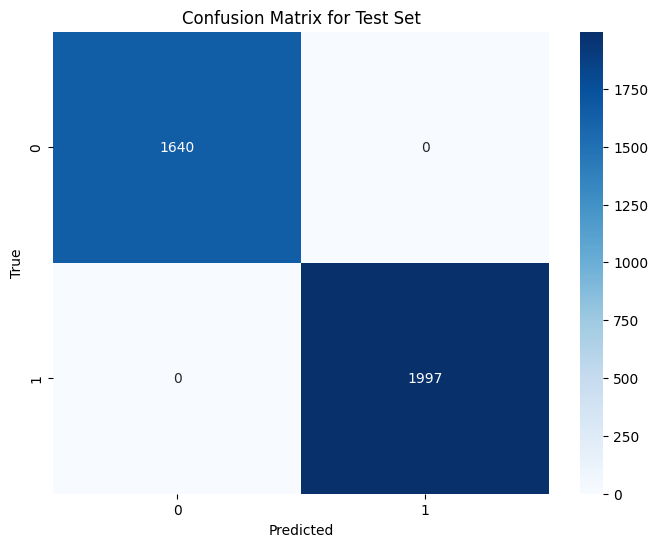

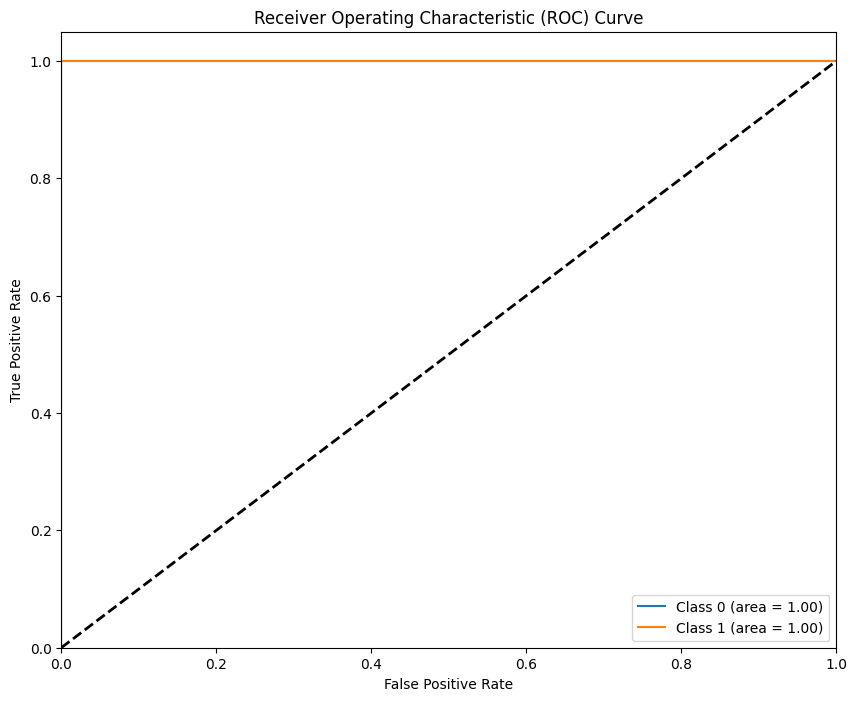

In [15]:
# Visualization of the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

# ROC Curve Visualization
n_classes = y_test_proba.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Saving the best model

In [16]:
import pickle

# Define the filenames
model_filename = 'best_model.pkl'
scaler_filename = 'scaler.pkl'

# Save the model to a pickle file
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

# Save the scaler to a pickle file
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Model saved to {model_filename}")
print(f"Scaler saved to {scaler_filename}")


Model saved to best_model.pkl
Scaler saved to scaler.pkl


In [17]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

with open(scaler_filename, 'rb') as file:
    loaded_scaler = pickle.load(file)

### Predicting the model locally

In [18]:
# Function to make predictions
def make_prediction(model, scaler, input_data):
    # Convert input data to a numpy array and reshape
    input_data_as_numpy_array = np.asarray(input_data)
    input_data_reshaped = input_data_as_numpy_array.reshape(1, -1)

    # Scale the input data using the loaded scaler
    scaled_data = scaler.transform(input_data_reshaped)
    print(f'Scaled input data: {scaled_data}')

    # Make prediction
    prediction = model.predict(scaled_data)
    print(f'Prediction: {prediction}')

    # Interpret the prediction based on your model's output
    # For example, if it's a binary classification model:
    if prediction[0] == 0:
        print('Prediction result: Class 0')
    else:
        print('Prediction result: Class 1')

In [19]:
# Example input data (replace with your actual features)
# Assuming your features are: id, Area, MajorAxisLength, MinorAxisLength, Eccentricity,
# ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation
input_data1 = (3145, 5644, 105.7856, 70.42822, 0.74616, 5929, 84.771, 0.672, 291.697, 0.833, 1.50)
make_prediction(loaded_model, loaded_scaler, input_data1)


Scaled input data: [[0.17289925 0.40608741 0.27079079 0.74699879 0.23860525 0.41542659
  0.4900504  0.57369638 0.30395896 0.88851139 0.05531827]]
Prediction: [0]
Prediction result: Class 0


In [20]:

input_data2 = (2, 15.0, 6.0, 4.0, 0.6, 18.0, 5.0, 0.9, 25.0, 0.95, 1.5)
make_prediction(loaded_model, loaded_scaler, input_data2)

Scaled input data: [[ 5.49934008e-05 -3.26092612e-01 -6.69006358e-01 -6.82319259e-01
  -2.65830668e-01 -3.17584325e-01 -9.00902304e-01  1.02667601e+00
  -5.52222179e-01  1.07189285e+00  5.53182688e-02]]
Prediction: [1]
Prediction result: Class 1
